In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

# 1. Components of The Polya Process

 - **Initial Setup**: The network consists of investors (Silicon Valley Bank etc.), where each investor has an urn containing red balls (negative sentiment) and black balls (positive sentiment). The number of balls in each urn is based on the investor’s size and assets.
 - **Sentiment Contagion**: Each investor's urn is influenced by its neighbors through a super urn, which combines sentiment from all neighboring investors. If a red ball is drawn, negative sentiment increases in the investor's urn, and if a black ball is drawn, positive sentiment increases. The process mimics how rumors or sentiment spread across connected investors.
 - **Reinforcement of Assets**: When a sentiment ball is drawn, additional sentiment balls are added to the urn. The number of sentiment balls added depends on the investor's assets, as well as whether sentiment is positive or negative. For instance:
 -- **Positive Sentiment**: If a black ball is drawn, additional black balls are added based on the investor’s assets and the total assets of their neighboring institutions.
 -- **Negative Sentiment**: Similarly, if a red ball is drawn, additional red balls are added based on the same asset-weighted process.
 - **Group-based Asset Changes**: Depending on the proportion of positive or negative sentiment balls in an investor's urn, assets are either bought or sold. This is grouped into two categories:
 -- **Group 1**: If positive sentiment is between 50-75%, a fraction of the investor’s assets are bought (10%).
 -- **Group 2**: If positive sentiment exceeds 75%, more assets are bought (20%).

# 2. Metro Bank Simulation

**Investors**:
 - Private Shareholders (142 nodes): Holding **243,515** shares.
 - Banks (3 nodes): Holding **10,210** shares.
 - Nominees (392 nodes): Holding **95,164,712** shares.
 Each investor is represented by a node, and their sentiment (positive (black) to negative (red) will influence how assets are reinforceed or diminished. 
 
**Goals**:
 - Model the spread of sentiment over a time period of **??1 Months (30 Steps)??**
 - Vizualize the impact on each investor by node size and colour gradient
 - Track the total sentiment
 - Vizualization of the contagion spreading and the nodes changing dynamically. 

In [61]:
def initialize_investor_groups():
    investors = {
        'Shareholders': {'initial_assets': 2243515, 'current_assets': 2243515, 'sentiment': 95, 'steps_since_change': 0},
        'Banks': {'initial_assets': 10210, 'current_assets': 10210, 'sentiment': 85, 'steps_since_change': 0},
        'Nominees': {'initial_assets': 95164712, 'current_assets': 95164712, 'sentiment': 90, 'steps_since_change': 0}
    }
    return investors

In [62]:
# simulating Metro Bank crisis
def update_sentiment(investors, step):
    # crisis events at steps 
    if step == 10:
        for group in investors:
            investors[group]['sentiment'] -= 10  # external event causes drop
            investors[group]['steps_since_change'] = 0  # reset counter - a major change just occurred
    elif step == 20:
        for group in investors:
            investors[group]['sentiment'] -= 15  # another sentiment drop
            investors[group]['steps_since_change'] = 0
    elif step == 30:
        for group in investors:
            investors[group]['sentiment'] += 5  # positive sentiment event (EXPERIMENT)
            investors[group]['steps_since_change'] = 0

    # natural shifts after no change for 3 steps
    apply_natural_shift(investors)
    # bound sentiment 10 to 100
    for group in investors:
        investors[group]['sentiment'] = max(10, min(100, investors[group]['sentiment']))

In [63]:
# natural shift 
def apply_natural_shift(investors):
    for group in investors:
        # if 3 steps have passed since last major sentiment change
        if investors[group]['steps_since_change'] >= 3:
            # small natural shift
            random_shift = random.uniform(0.005, 0.02)  # shift between 0.5% and 2%
            if investors[group]['sentiment'] < 100:
                investors[group]['sentiment'] *= (1 - random_shift)  # decrease in sentiment
            else:
                investors[group]['sentiment'] *= (1 + random_shift)  # increase if sentiment was rising
        # counter since last major change
        investors[group]['steps_since_change'] += 1

In [64]:
# assets based on proportional sentiment change
def update_assets(investors, prev_sentiment):
    for group in investors:
        # change in sentiment
        current_sentiment = investors[group]['sentiment']
        delta_sentiment = current_sentiment - prev_sentiment[group]

        # update assets proportionally to the sentiment change
        if delta_sentiment < 0:
            # decrease assets proportional to the magnitude of sentiment drop
            sentiment_proportional_drop = abs(delta_sentiment) / prev_sentiment[group]
            investors[group]['current_assets'] *= (1 - sentiment_proportional_drop)
        elif delta_sentiment > 0:
            # increase assets "---"
            sentiment_proportional_rise = delta_sentiment / prev_sentiment[group]
            investors[group]['current_assets'] *= (1 + sentiment_proportional_rise)

        investors[group]['current_assets'] = max(5000, investors[group]['current_assets'])  # prevent a collapse

In [65]:
# visualization for percentage change in assets (Total Assets was not a great visualization since the difference in shares 
# held is very large between Private Shareholders, Banks, and especially Nominees).

def visualize_simulation(investors, steps=40):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2)  

    # fixed positions for the investor groups
    positions = np.array([[0.5, 0.5], [0, 0], [-0.5, -0.5]])

    # store sentiment and percentage asset changes over time
    sentiment_history = {group: [] for group in investors}
    asset_percentage_history = {group: [] for group in investors}
    
    # initialize previous sentiment tracker
    prev_sentiment = {group: investors[group]['sentiment'] for group in investors}

    # calculate relative asset size
    def relative_asset_size(group):
        return investors[group]['current_assets'] / investors[group]['initial_assets']

    # plot for visualization
    def update_plot(step):
        ax.clear()  
        update_sentiment(investors, step)  # update sentiment at each step
        update_assets(investors, prev_sentiment)  # update assets based on sentiment change
        
        # update previous sentiment for the next step
        prev_sentiment.update({group: investors[group]['sentiment'] for group in investors})

        # store the ball sizes and colors
        sizes = []
        colors = []

        # iterate through the investor groups to update size and color
        for i, group in enumerate(investors):
            relative_size = relative_asset_size(group)
            sizes.append(relative_size * 1000) 
            sentiment = investors[group]['sentiment']
            colors.append((1 - sentiment / 100, 0, 0))  

            # store sentiment and percentage asset change
            sentiment_history[group].append(sentiment)
            asset_percentage_history[group].append(relative_size * 100)

        # plot for the 3 investors 
        scatter = ax.scatter(positions[:, 0], positions[:, 1], s=sizes, color=colors, alpha=0.8)

        # lines (connections) between the investors
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                ax.plot([positions[i, 0], positions[j, 0]], [positions[i, 1], positions[j, 1]], color='black', alpha=0.5)

        for i, group in enumerate(investors):
            ax.text(positions[i, 0], positions[i, 1] + 0.1, f"{group}\nAssets: {int(investors[group]['current_assets'])}",
                    ha='center', fontsize=12)

        ax.set_title(f"Step {step + 1}")

    anim = animation.FuncAnimation(fig, update_plot, frames=steps, interval=500)

    return anim, sentiment_history, asset_percentage_history

In [66]:
def plot_sentiment_history(sentiment_history):
    plt.figure(figsize=(10, 6))
    for group, sentiments in sentiment_history.items():
        plt.plot(sentiments, label=group)
    plt.xlabel("Step")
    plt.ylabel("Sentiment")
    plt.title("Sentiment Change Over Time")
    plt.legend()
    plt.show()

In [67]:
def plot_asset_percentage_history(asset_percentage_history):
    plt.figure(figsize=(10, 6))
    for group, asset_percentages in asset_percentage_history.items():
        plt.plot(asset_percentages, label=group)
    plt.xlabel("Step")
    plt.ylabel("Asset Percentage (%)")
    plt.title("Asset Percentage Change Over Time")
    plt.legend()
    plt.show()

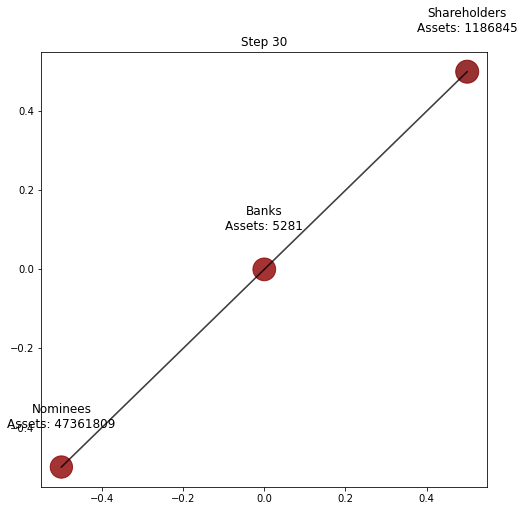

In [70]:
investors = initialize_investor_groups()

anim, sentiment_history, asset_percentage_history = visualize_simulation(investors, steps=30)
HTML(anim.to_jshtml())

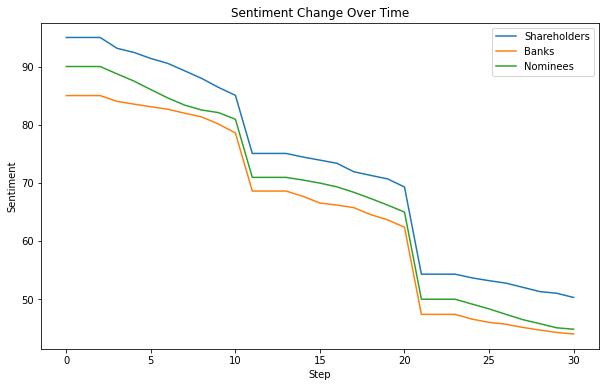

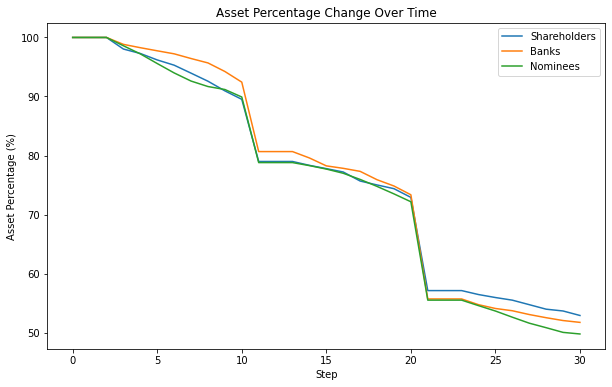

In [71]:
plot_sentiment_history(sentiment_history)
plot_asset_percentage_history(asset_percentage_history)

##  2.1 Improvements

 - Possibly add a def function that gives meaning to the investors position on the map, whether it is shared assets that draw them in closer etc.

# 0. Appendix (Predictive Modeling / Importing Sentiment Data)

In [ ]:
import pandas as pd
import requests

In [ ]:
# function to fetch news sentiment data from FMP (Can be drawn from anywhere - first thing I found)
def fetch_news_df(api_key, page):
    url = f'https://financialmodelingprep.com/api/v4/stock-news-sentiments-rss-feed?page={page}&apikey={api_key}'
    response = requests.get(url).json()
    return pd.DataFrame(response)

api_key = 'qhj17FO7DWK1NGTrdbcsxws2MkzANCAu'
news_data = fetch_news_df(api_key, page=0)
news_data.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

def preprocess_news_data(data):
    data = data.dropna()
    le = LabelEncoder()
    data['sentiment'] = le.fit_transform(data['sentiment'])
    
    vectorizer = CountVectorizer(max_features=1000)
    text_vector = vectorizer.fit_transform(data['text'])
    return data, text_vector, le, vectorizer

news_data, text_vector, le, vectorizer = preprocess_news_data(news_data)

# can experiment with TF-IDF (Term Frequency-Inverse Document Frequency) instead of Count Vectorizer for a more 
# complex feature representation.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier

X = df_hb1_nocont_sentilink.drop(columns = ['no_contact'])
y = df_hb1_nocont_sentilink['no_contact']

X_hb1nc_sentilink_train, X_hb1nc_sentilink_other, y_hb1nc_sentilink_train, y_hb1nc_sentilink_other = train_test_split(X, y, test_size=0.3, random_state=42)
X_hb1nc_sentilink_vald, X_hb1nc_sentilink_test, y_hb1nc_sentilink_vald, y_hb1nc_sentilink_test = train_test_split(X_hb1nc_sentilink_other, y_hb1nc_sentilink_other, test_size=0.5, random_state=42)

In [ ]:
model_hb1nc_sentilink = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model_hb1nc_sentilink.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train)

In [ ]:
y_pred_hb1nc_sentilink = model_hb1nc_sentilink.predict(X_hb1nc_sentilink_test)
y_pred_prob_hb1nc_sentilink = model_hb1nc_sentilink.predict_proba(X_hb1nc_sentilink_test)[:, 1]
accuracy_hb1nc_sentilink = accuracy_score(y_hb1nc_sentilink_test, y_pred_hb1nc_sentilink)
roc_auc_hb1nc_sentilink = roc_auc_score(y_hb1nc_sentilink_test, y_pred_prob_hb1nc_sentilink)
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_test, y_pred_prob_hb1nc_sentilink, pos_label=1)

print('AUC PR score for hb1 no contact sentilink: ' + str(metrics.auc(recall, precision)))
print(f"Accuracy score for hb1 no contact sentilink: {accuracy_hb1nc_sentilink}")
print(f"ROC AUC Score for hb1 no contact sentilink: {roc_auc_hb1nc_sentilink}")

In [ ]:
# calculate 'scale_pos_weight' as sum(negative class)/sum(positive class)
scale_pos_weight = y_hb1nc_sentilink_train.value_counts()[0] / y_hb1nc_sentilink_train.value_counts()[1]
round(scale_pos_weight,2)

In [ ]:
eval_set = [(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train), (X_hb1nc_sentilink_vald, y_hb1nc_sentilink_vald)]

def train_model(n_estimators, subsample, reg_lambda, reg_alpha, min_child_weight, max_depth, learning_rate, colsample_bytree):
    params = {
        'n_estimators': int(round(n_estimators)),
        'subsample': subsample,
        'reg_lambda': int(round(reg_lambda)),
        'reg_alpha': int(round(reg_alpha)),
        'min_child_weight': round(min_child_weight),
        'max_depth': int(round(max_depth)),
        'learning_rate': learning_rate,
        'colsample_bytree': colsample_bytree
    }
    xgbc_hb1nc = XGBClassifier(n_jobs = -1, eval_metric = ['error','aucpr'], early_stopping_rounds=20, objective='binary:logistic', **params, scale_pos_weight = scale_pos_weight)
    xgbc_hb1nc.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train, eval_set=eval_set, verbose=50)
    return xgbc_hb1nc.evals_result()['validation_1']['aucpr'][-1]

xgb_param_grid = {
    'n_estimators' : (50, 201),
    'subsample': (0.7, 0.95),
    'reg_lambda': (1, 60),
    'reg_alpha': (1, 20), 
    'min_child_weight':(10, 51),
    'max_depth' : (2, 3),
    'learning_rate' : (0.01, 0.2),
    'colsample_bytree': (0.6, 0.95)
}

optimizer = BayesianOptimization(
    f=train_model,
    pbounds=xgb_param_grid,
    #random_state=1,
)
optimizer.maximize(init_points=2, n_iter=23)
 
print(optimizer.max)

In [ ]:
xgbc_hb1nc.get_xgb_params()

In [ ]:
print("Train full model with the best hyperparameter set...")
 
 
eval_set = [(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train), (X_hb1nc_sentilink_vald, y_hb1nc_sentilink_vald)]
xgbc_hb1nc = XGBClassifier(n_estimators = int(optimizer.max['params']['n_estimators']), 
                         n_jobs = -1, 
                         subsample = round(optimizer.max['params']['subsample'],2), 
                         reg_lambda = round(optimizer.max['params']['reg_lambda'],2), 
                         reg_alpha = round(optimizer.max['params']['reg_alpha'],2),
                         min_child_weight = round(optimizer.max['params']['min_child_weight'],2),
                         max_depth = int(optimizer.max['params']['max_depth']), 
                         learning_rate= round(optimizer.max['params']['learning_rate'],2),  
                         colsample_bytree = round(optimizer.max['params']['colsample_bytree'],2), 
                         scale_pos_weight = scale_pos_weight,
                         objective='binary:logistic',
                         eval_metric = ['error','aucpr'],
                         early_stopping_rounds=20
                        )
 
## model used for values below as it takes the best hyperparameter class 
xgbc_hb1nc.fit(X_hb1nc_sentilink_train, y_hb1nc_sentilink_train, eval_set=eval_set, verbose=50)

#AUC
simple_split_pred_train = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_train)
fpr, tpr, thresholds = metrics.roc_curve(y_hb1nc_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC full train set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_train, simple_split_pred_train[:,1], pos_label=1)
print('AUC PR full train set: ' + str(metrics.auc(recall, precision)))
 
simple_split_pred_vald = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_vald)
fpr, tpr, thresholds = metrics.roc_curve(y_hb1nc_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC full vald set: ' + str(metrics.auc(fpr, tpr)))
precision, recall, thresholds = precision_recall_curve(y_hb1nc_sentilink_vald, simple_split_pred_vald[:,1], pos_label=1)
print('AUC PR full vald set: ' + str(metrics.auc(recall, precision)))
 
# simple_split_pred_test = xgbc_hb1nc.predict_proba(X_test)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, simple_split_pred_test[:,1], pos_label=1)
# print('AUC full test set: ' + str(metrics.auc(fpr, tpr)))
# precision, recall, thresholds = precision_recall_curve(y_test, simple_split_pred_test[:,1], pos_label=1)
# print('AUC PR full test set: ' + str(metrics.auc(recall, precision)))
 
binary_threshold_eval = thresholds[np.argmax(tpr-fpr)]
print('Threshold that generates max(tpr-fpr) for test population: ' + str(binary_threshold_eval))
binary_pred_eval = np.where(simple_split_pred_vald[:,1] >= binary_threshold_eval, 1, 0)
display(pd.crosstab(binary_pred_eval, np.array(y_hb1nc_sentilink_vald.to_list())))
print('Full model predicted accuracy: ' + str(accuracy_score(binary_pred_eval, y_hb1nc_sentilink_vald)))

In [ ]:
### Taken from Mitanshu CAP Curve
# Sort predicted probabilities in descending order
Probas_test = xgbc_hb1nc.predict_proba(X_hb1nc_sentilink_test)[:,1]
sorted_indices = np.argsort(Probas_test)[::-1]
sorted_probs = Probas_test[sorted_indices]
sorted_outcomes = y_hb1nc_sentilink_test.values[sorted_indices]
# Calculate cumulative numbers and percentages of bad customers
total_bad_customers = np.sum(sorted_outcomes)
cumulative_bad_customers = np.cumsum(sorted_outcomes)
cumulative_percent_bad = cumulative_bad_customers / total_bad_customers
# Create the CAP curve
total_borrowers = len(Probas_test)
cumulative_percent_borrowers = np.arange(1, total_borrowers + 1) / total_borrowers
# Plot the CAP curve
plt.plot(cumulative_percent_borrowers, cumulative_percent_bad, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.plot([0, total_bad_customers / total_borrowers, 1], [0, 1, 1], linestyle=":", label="Perfect")
plt.xlabel("Percentage of Borrowers")
plt.ylabel("Percentage of Bad Customers")
plt.title("Cumulative Accuracy Profile (CAP) Curve")
plt.legend()
plt.show()
# Calculate the area under the CAP curve
area_model = np.trapz(cumulative_percent_bad, cumulative_percent_borrowers)
area_random = 0.5  # Area under the random model (diagonal line)
area_perfect = np.trapz([0, 1, 1], [0, total_bad_customers / total_borrowers, 1])
# Compute the accuracy ratio
accuracy_ratio = (area_model - area_random) / (area_perfect - area_random)
print(f"Accuracy Ratio: {accuracy_ratio:.4f}")

In [ ]:
# Example usage
sentiment_labels = news_data['sentiment']
nb_clf, xg_clf, train_x, test_x, train_y, test_y = train_sentiment_models(text_vector, sentiment_labels)